# Car Price Prediction Using Supervised Machine Learning Regression Algorithms

## PART 1: Business Understanding

## PART 2: Data Understanding, Preparation and Exploration

In [0]:
!pip install xgboost

     |████████████████████████████████| 173.5 MB 5.2 kB/s 
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
!pip install hyperopt

     |████████████████████████████████| 1.6 MB 6.4 MB/s 
     |████████████████████████████████| 198 kB 54.9 MB/s 
     |████████████████████████████████| 76 kB 2.9 MB/s 
     |████████████████████████████████| 1.9 MB 33.0 MB/s 
     |████████████████████████████████| 829 kB 22.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=45d29117c47f0a8210bc0c2ed6263b036b28cc5a12b2907accd8740ca99d3abd
  Stored in directory: /root/.cache/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built future
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
import os
import joblib
import math
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit
from pyspark.sql import SparkSession

from pyspark.sql.functions import col,isnan,when,count

from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pyspark.ml.feature import StandardScaler, MinMaxScaler

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor

In [0]:
spark = SparkSession.builder.appName("car_price_prediction").getOrCreate()

In [0]:
account_key = "2PENU3etd0E7Bfiw7jjLc/6W2AfFugw72HNTd6dW0F44B+JNbMuwerzU8g9f83fYYm4WZBoq0DlHVk8Lc9oY4A=="
spark.conf.set("fs.azure.account.key.dfstorageaccountadls1.blob.core.windows.net", account_key)

# path to the datasets
datasets = dbutils.fs.ls("wasbs://cardatacontainer1@dfstorageaccountadls1.blob.core.windows.net")

In [0]:
def readCarData(datasets):
  
  car_data = []
  
  for i in range(len(datasets)):
    
    file_path = datasets[i][0]
    
    df = spark.read \
          .format('csv') \
          .option("inferSchema", "true") \
          .option("header", "true") \
          .load(file_path)
    
    car_data.append(df)
    
  return car_data

In [0]:
# read the datasets
car_data = readCarData(datasets)

In [0]:
audi, bmw, ford, hyundai, mercedes, skoda, toyota, vauxhall, volks_wagen =  car_data[0], car_data[1], car_data[2], car_data[3], car_data[4], car_data[5], car_data[6], car_data[7], car_data[8]

In [0]:
car_list = [audi, bmw, ford, hyundai, mercedes, skoda, toyota, vauxhall, volks_wagen]

car_names = ['audi', 'bmw', 'ford', 'hyundai', 'mercedes', 'skoda', 'toyota', 'vauxhall', 'volks_wagen']

for i, car in enumerate(car_list):
  print('#======= ' + str(car_names[i]) + ' =========#')
  car.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in car.columns]).show()

#======= audi =========#
+-----+----+-----+------------+-------+--------+---+---+----------+
|model|year|price|transmission|mileage|fuelType|tax|mpg|engineSize|
+-----+----+-----+------------+-------+--------+---+---+----------+
|    0|   0|    0|           0|      0|       0|  0|  0|         0|
+-----+----+-----+------------+-------+--------+---+---+----------+

#======= bmw =========#
+-----+----+-----+------------+-------+--------+---+---+----------+
|model|year|price|transmission|mileage|fuelType|tax|mpg|engineSize|
+-----+----+-----+------------+-------+--------+---+---+----------+
|    0|   0|    0|           0|      0|       0|  0|  0|         0|
+-----+----+-----+------------+-------+--------+---+---+----------+

#======= ford =========#
+-----+----+-----+------------+-------+--------+---+---+----------+
|model|year|price|transmission|mileage|fuelType|tax|mpg|engineSize|
+-----+----+-----+------------+-------+--------+---+---+----------+
|    0|   0|    0|           0|      0| 

In [0]:
car_list = [audi, bmw, ford, hyundai, mercedes, skoda, toyota, vauxhall, volks_wagen]

for car in car_list:
  car.groupBy('model').count().show()

+-----+-----+
|model|count|
+-----+-----+
|   A7|  122|
|  SQ7|    8|
|   A4| 1381|
|  RS3|   33|
|   S3|   18|
|  RS5|   29|
|  RS6|   39|
|  SQ5|   16|
|   S4|   12|
|   Q8|   69|
|  RS4|   31|
|   A1| 1347|
|   A3| 1929|
|   Q2|  822|
|  RS7|    1|
|   Q7|  397|
|   Q3| 1417|
|   R8|   28|
|   S5|    3|
|   Q5|  877|
+-----+-----+
only showing top 20 rows

+---------+-----+
|    model|count|
+---------+-----+
|       X7|   55|
|       Z3|    7|
|       X6|  106|
|       X2|  288|
| 3 Series| 2443|
| 2 Series| 1229|
|       X4|  179|
|       X5|  468|
|       M4|  125|
|       i3|   43|
| 4 Series|  995|
| 8 Series|   39|
| 6 Series|  108|
|       M3|   27|
|       M2|   21|
|       Z4|  108|
|       i8|   17|
| 7 Series|  106|
|       X3|  551|
| 1 Series| 1969|
+---------+-----+
only showing top 20 rows

+--------------------+-----+
|               model|count|
+--------------------+-----+
|     Transit Tourneo|    1|
|              Ranger|    1|
|                Puma|   80|
|     

## PART 3: Feature Engineering

In [0]:
def featureEngineerCarMake(df, car_make=None):
  """
    Creates and returns a dataframe with a new feature 'make' 
    engineered from the car model and drops the car model as a 
    final step.
  """
    
  return df.withColumn("make", lit(car_make)).drop('model')

In [0]:
audi = featureEngineerCarMake(audi, car_make="AUDI")
bmw = featureEngineerCarMake(bmw, car_make="BMW")
ford = featureEngineerCarMake(ford, car_make="FORD")
hyundai = featureEngineerCarMake(hyundai, car_make="HYUNDAI")
mercedes = featureEngineerCarMake(mercedes, car_make="MERCEDES")
skoda = featureEngineerCarMake(skoda, car_make="SKODA")
toyota = featureEngineerCarMake(toyota, car_make="TOYOTA")
vauxhall = featureEngineerCarMake(vauxhall, car_make="VAUXHALL")
volks_wagen = featureEngineerCarMake(volks_wagen, car_make="VW")

In [0]:
hyundai = hyundai.withColumnRenamed('tax(£)', 'tax')

In [0]:
car_dataset_merged = audi.union(bmw).union(ford).union(hyundai).union(mercedes).union(skoda).union(toyota).union(vauxhall).union(volks_wagen)
car_dataset_merged.cache()
car_dataset_merged.toPandas().head()

year 
 price 
 transmission 
 mileage 
 fuelType 
 tax 
 mpg 
 engineSize 
 make 
 
 
 
 
 0 
 2017 
 12500 
 Manual 
 15735 
 Petrol 
 150 
 55.4 
 1.4 
 AUDI 
 
 
 1 
 2016 
 16500 
 Automatic 
 36203 
 Diesel 
 20 
 64.2 
 2.0 
 AUDI 
 
 
 2 
 2016 
 11000 
 Manual 
 29946 
 Petrol 
 30 
 55.4 
 1.4 
 AUDI 
 
 
 3 
 2017 
 16800 
 Automatic 
 25952 
 Diesel 
 145 
 67.3 
 2.0 
 AUDI 
 
 
 4 
 2019 
 17300 
 Manual 
 1998 
 Petrol 
 145 
 49.6 
 1.0 
 AUDI

In [0]:
car_dataset_merged.printSchema()

root
 |-- year: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- transmission: string (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- tax: integer (nullable = true)
 |-- mpg: double (nullable = true)
 |-- engineSize: double (nullable = true)
 |-- make: string (nullable = false)



In [0]:
for car in car_dataset_merged.head(5):
  print(car)
  print('\n')

Row(year=2017, price=12500, transmission='Manual', mileage=15735, fuelType='Petrol', tax=150, mpg=55.4, engineSize=1.4, make='AUDI')


Row(year=2016, price=16500, transmission='Automatic', mileage=36203, fuelType='Diesel', tax=20, mpg=64.2, engineSize=2.0, make='AUDI')


Row(year=2016, price=11000, transmission='Manual', mileage=29946, fuelType='Petrol', tax=30, mpg=55.4, engineSize=1.4, make='AUDI')


Row(year=2017, price=16800, transmission='Automatic', mileage=25952, fuelType='Diesel', tax=145, mpg=67.3, engineSize=2.0, make='AUDI')


Row(year=2019, price=17300, transmission='Manual', mileage=1998, fuelType='Petrol', tax=145, mpg=49.6, engineSize=1.0, make='AUDI')




In [0]:
car_dataset_merged.createOrReplaceTempView("car_dataset")

In [0]:
%sql
SELECT transmission, count(*) as count
FROM car_dataset
GROUP BY 1

transmission count Semi-Auto 22677 Automatic 20056 Manual 56445 Other 9

In [0]:
%sql
SELECT fuelType as FuelType, count(*) as count
FROM car_dataset
GROUP BY 1

FuelType count Diesel 40928 Hybrid 3078 Petrol 54928 Other 247 Electric 6

In [0]:
%sql
SELECT make as Make, count(*) as count
FROM car_dataset
GROUP BY 1

Make count AUDI 10668 BMW 10781 FORD 17965 HYUNDAI 4860 MERCEDES 13119 SKODA 6267 TOYOTA 6738 VAUXHALL 13632 VW 15157

In [0]:
%sql
SELECT year, count(*) as count
FROM car_dataset
GROUP BY 1

year count 2003 34 2007 163 2018 13664 2015 7645 2006 86 2013 2603 1997 4 2014 4085 2019 26771 2004 52 1998 8 2020 4465 2012 634 2009 278 2016 15850 2005 69 2010 340 2011 432 2008 200 2017 21733 2002 31 1996 2 2001 20 2000 9 1999 6 2060 1 1970 2

In [0]:
%sql
select fuelType, round(AVG(price),2) as AVG_Price
from car_dataset
group by fuelType

fuelType AVG_Price Diesel 19339.49 Hybrid 19289.59 Petrol 14775.05 Other 17443.34 Electric 16645.33

In [0]:
%sql
select transmission, year, round(AVG(price),2) as AVG_Price
from car_dataset
where year >= 2015
group by transmission, year
order by year

transmission year AVG_Price Automatic 2015 15069.01 Other 2015 12895.0 Semi-Auto 2015 16362.92 Manual 2015 9361.22 Semi-Auto 2016 18169.79 Manual 2016 10702.73 Other 2016 18700.0 Automatic 2016 16796.68 Other 2017 14745.0 Manual 2017 11573.13 Semi-Auto 2017 19314.41 Automatic 2017 18654.21 Manual 2018 12875.4 Automatic 2018 21476.87 Semi-Auto 2018 23605.27 Manual 2019 16217.52 Other 2019 17998.0 Semi-Auto 2019 29152.12 Automatic 2019 29108.37 Manual 2020 18983.43 Semi-Auto 2020 34323.02 Automatic 2020 32905.42 Automatic 2060 6495.0

In [0]:
%sql
select fuelType, year, round(AVG(price),2) as AVG_Price
from car_dataset
where year >= 2015
group by fuelType, year
order by year

fuelType year AVG_Price Other 2015 16148.07 Petrol 2015 9923.17 Electric 2015 15199.5 Hybrid 2015 13156.1 Diesel 2015 12936.38 Diesel 2016 14987.1 Other 2016 15153.64 Petrol 2016 11150.53 Electric 2016 16824.67 Hybrid 2016 16271.45 Hybrid 2017 17702.33 Electric 2017 18999.0 Other 2017 14058.64 Petrol 2017 12310.71 Diesel 2017 17180.72 Hybrid 2018 18484.31 Other 2018 13733.33 Diesel 2018 20743.82 Petrol 2018 14264.1 Hybrid 2019 25604.51 Diesel 2019 27888.21 Other 2019 22730.39 Petrol 2019 20371.73 Diesel 2020 34425.06 Petrol 2020 24830.34 Hybrid 2020 30370.16 Other 2020 23919.93 Petrol 2060 6495.0

In [0]:
%sql
select make, year, round(AVG(price),2) as AVG_Price
from car_dataset
where year >= 2015
group by make, year
order by year

make year AVG_Price TOYOTA 2015 9909.58 VAUXHALL 2015 7411.72 HYUNDAI 2015 8549.8 VW 2015 11100.35 MERCEDES 2015 16731.78 AUDI 2015 15128.24 BMW 2015 15199.75 SKODA 2015 9131.18 FORD 2015 8778.17 BMW 2016 16638.4 MERCEDES 2016 19307.89 SKODA 2016 10336.26 VAUXHALL 2016 8624.57 TOYOTA 2016 11704.08 VW 2016 12692.36 AUDI 2016 16908.73 FORD 2016 10665.67 HYUNDAI 2016 10651.35 SKODA 2017 12012.35 FORD 2017 11965.69 TOYOTA 2017 12187.6 AUDI 2017 19951.62 BMW 2017 19267.17 HYUNDAI 2017 11454.44 MERCEDES 2017 21514.31 VAUXHALL 2017 10094.61 VW 2017 14455.09 FORD 2018 13157.89 TOYOTA 2018 12382.22 AUDI 2018 26296.71 HYUNDAI 2018 12998.2 VAUXHALL 2018 11784.86 VW 2018 17969.71 MERCEDES 2018 25720.16 SKODA 2018 14058.38 BMW 2018 22721.66 FORD 2019 17176.45 AUDI 2019 30410.75 MERCEDES 2019 31290.02 BMW 2019 31025.86 SKODA 2019 18401.02 VW 2019 22382.35 HYUNDAI 2019 18077.42 TOYOTA 2019 16718.92 VAUXHALL 2019 13367.36 BMW 2020 35377.68 AUDI 2020 35967.07 FORD 2020 20819.87 MERCEDES 2020 35433.28 HYUNDAI 2020 19752.06 SKODA 2020 22589.63 VAUXHALL 2020 16304.63 TOYOTA 2020 22968.67 VW 2020 23818.38 FORD 2060 6495.0

We can see that there are records for year far beyond 2021. These are clearly bad data and need to be deleted.'

In [0]:
# Number of records with year greater than 2021
car_dataset_merged.where(car_dataset_merged.year > 2021).count()

Out[19]: 1

In [0]:
car_dataset_merged = car_dataset_merged.where(car_dataset_merged.year <= 2021)
type(car_dataset_merged)

Out[20]: pyspark.sql.dataframe.DataFrame

In [0]:
car_dataset_merged.createOrReplaceTempView("car_dataset_new")

In [0]:
%sql
select make, year, round(AVG(price),2) as AVG_Price
from car_dataset_new
where year >= 2015
group by make, year
order by year

make year AVG_Price TOYOTA 2015 9909.58 VAUXHALL 2015 7411.72 HYUNDAI 2015 8549.8 VW 2015 11100.35 MERCEDES 2015 16731.78 AUDI 2015 15128.24 BMW 2015 15199.75 SKODA 2015 9131.18 FORD 2015 8778.17 BMW 2016 16638.4 MERCEDES 2016 19307.89 SKODA 2016 10336.26 VAUXHALL 2016 8624.57 TOYOTA 2016 11704.08 VW 2016 12692.36 AUDI 2016 16908.73 FORD 2016 10665.67 HYUNDAI 2016 10651.35 SKODA 2017 12012.35 FORD 2017 11965.69 TOYOTA 2017 12187.6 AUDI 2017 19951.62 BMW 2017 19267.17 HYUNDAI 2017 11454.44 MERCEDES 2017 21514.31 VAUXHALL 2017 10094.61 VW 2017 14455.09 FORD 2018 13157.89 TOYOTA 2018 12382.22 AUDI 2018 26296.71 HYUNDAI 2018 12998.2 VAUXHALL 2018 11784.86 VW 2018 17969.71 MERCEDES 2018 25720.16 SKODA 2018 14058.38 BMW 2018 22721.66 FORD 2019 17176.45 AUDI 2019 30410.75 MERCEDES 2019 31290.02 BMW 2019 31025.86 SKODA 2019 18401.02 VW 2019 22382.35 HYUNDAI 2019 18077.42 TOYOTA 2019 16718.92 VAUXHALL 2019 13367.36 AUDI 2020 35967.07 BMW 2020 35377.68 FORD 2020 20819.87 HYUNDAI 2020 19752.06 MERCEDES 2020 35433.28 TOYOTA 2020 22968.67 SKODA 2020 22589.63 VAUXHALL 2020 16304.63 VW 2020 23818.38

In [0]:
def stringIndexCategoryFeature(df):
  
  cat_feature = ['transmission', 'fuelType', 'make']
  
  indexed = df
  
  for cat in cat_feature:
    
    new_cat = cat + "_cat"
    
    indexer = StringIndexer(inputCol=cat, outputCol=new_cat)
    
    indexed_new = indexer.fit(indexed).transform(indexed)
    
    indexed = indexed_new
    
  return indexed_new
  

In [0]:
new_car_data = stringIndexCategoryFeature(car_dataset_merged)
display(new_car_data.show(5))

+----+-----+------------+-------+--------+---+----+----------+----+----------------+------------+--------+
|year|price|transmission|mileage|fuelType|tax| mpg|engineSize|make|transmission_cat|fuelType_cat|make_cat|
+----+-----+------------+-------+--------+---+----+----------+----+----------------+------------+--------+
|2017|12500|      Manual|  15735|  Petrol|150|55.4|       1.4|AUDI|             0.0|         0.0|     5.0|
|2016|16500|   Automatic|  36203|  Diesel| 20|64.2|       2.0|AUDI|             2.0|         1.0|     5.0|
|2016|11000|      Manual|  29946|  Petrol| 30|55.4|       1.4|AUDI|             0.0|         0.0|     5.0|
|2017|16800|   Automatic|  25952|  Diesel|145|67.3|       2.0|AUDI|             2.0|         1.0|     5.0|
|2019|17300|      Manual|   1998|  Petrol|145|49.6|       1.0|AUDI|             0.0|         0.0|     5.0|
+----+-----+------------+-------+--------+---+----+----------+----+----------------+------------+--------+
only showing top 5 rows



In [0]:
new_car_data.createOrReplaceTempView("stringIndexedData")

In [0]:
%sql
select transmission, transmission_cat, count(*)
from stringIndexedData
group by 1, 2
order by 2

transmission transmission_cat count(1) Manual 0.0 56445 Semi-Auto 1.0 22677 Automatic 2.0 20055 Other 3.0 9

In [0]:
%sql
select fuelType, fuelType_cat, count(*)
from stringIndexedData
group by 1, 2
order by 2

fuelType fuelType_cat count(1) Petrol 0.0 54927 Diesel 1.0 40928 Hybrid 2.0 3078 Other 3.0 247 Electric 4.0 6

In [0]:
%sql
select make, make_cat, count(*)
from stringIndexedData
group by 1, 2
order by 2

make make_cat count(1) FORD 0.0 17964 VW 1.0 15157 VAUXHALL 2.0 13632 MERCEDES 3.0 13119 BMW 4.0 10781 AUDI 5.0 10668 TOYOTA 6.0 6738 SKODA 7.0 6267 HYUNDAI 8.0 4860

In [0]:
new_car_data.printSchema()

root
 |-- year: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- transmission: string (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- tax: integer (nullable = true)
 |-- mpg: double (nullable = true)
 |-- engineSize: double (nullable = true)
 |-- make: string (nullable = false)
 |-- transmission_cat: double (nullable = false)
 |-- fuelType_cat: double (nullable = false)
 |-- make_cat: double (nullable = false)



In [0]:
assember  = VectorAssembler(inputCols=['year',
                                       'mileage',
                                       'tax',
                                       'mpg',
                                       'engineSize',
                                       'transmission_cat',
                                       'fuelType_cat',
                                       'make_cat'],
                           outputCol='features')

vectorized_car_data = assember.transform(new_car_data)
vectorized_car_data.show(3)

+----+-----+------------+-------+--------+---+----+----------+----+----------------+------------+--------+--------------------+
|year|price|transmission|mileage|fuelType|tax| mpg|engineSize|make|transmission_cat|fuelType_cat|make_cat|            features|
+----+-----+------------+-------+--------+---+----+----------+----+----------------+------------+--------+--------------------+
|2017|12500|      Manual|  15735|  Petrol|150|55.4|       1.4|AUDI|             0.0|         0.0|     5.0|[2017.0,15735.0,1...|
|2016|16500|   Automatic|  36203|  Diesel| 20|64.2|       2.0|AUDI|             2.0|         1.0|     5.0|[2016.0,36203.0,2...|
|2016|11000|      Manual|  29946|  Petrol| 30|55.4|       1.4|AUDI|             0.0|         0.0|     5.0|[2016.0,29946.0,3...|
+----+-----+------------+-------+--------+---+----+----------+----+----------------+------------+--------+--------------------+
only showing top 3 rows



In [0]:
minMax = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics by fitting the StandardScaler
scalerModel = minMax.fit(vectorized_car_data)

# Normalize each feature to have unit standard deviation.
scaledCarData = scalerModel.transform(vectorized_car_data)
scaledCarData.drop('features').show(1)

+----+-----+------------+-------+--------+---+----+----------+----+----------------+------------+--------+--------------------+
|year|price|transmission|mileage|fuelType|tax| mpg|engineSize|make|transmission_cat|fuelType_cat|make_cat|      scaledFeatures|
+----+-----+------------+-------+--------+---+----+----------+----+----------------+------------+--------+--------------------+
|2017|12500|      Manual|  15735|  Petrol|150|55.4|       1.4|AUDI|             0.0|         0.0|     5.0|[0.94000000000000...|
+----+-----+------------+-------+--------+---+----+----------+----+----------------+------------+--------+--------------------+
only showing top 1 row



In [0]:
final_data = scaledCarData.select(['scaledFeatures', 'price'])

train_data, test_data = final_data.randomSplit([0.8, 0.2])

In [0]:
train_data.describe().show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|            79218|
|   mean|16820.87553333838|
| stddev|9890.266256077974|
|    min|              450|
|    max|           154998|
+-------+-----------------+



In [0]:
test_data.describe().show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             19968|
|   mean|16744.261067708332|
| stddev| 9772.998208696325|
|    min|               850|
|    max|            159999|
+-------+------------------+



### Define function to make predictions

In [0]:
def fitModelToCarData(regressor, data, model=None):
  
  # Instantiate Regression model
  if model == 'glr':
    rg = regressor(family="gaussian", 
                  link="identity", 
                  maxIter=100, 
                  regParam=0.1,
                  labelCol='price',
                  featuresCol='scaledFeatures')
  elif model == 'lr':
    rg = regressor(labelCol='price',
                   featuresCol="scaledFeatures", 
                   regParam=0.1,
                   maxIter=100)
  elif model == 'tree':
    rg = regressor(labelCol='price',
                   featuresCol="scaledFeatures")
  else:
    rg = regressor(labelCol='price',
                   featuresCol="scaledFeatures",
                   maxIter=10)
  
  # To the model to the training data
  rg_model = rg.fit(data[0])

  # Make predictions.
  rg_results = rg_model.transform(data[1])
  
  # ================================== COMPUTE RMSE VALUE ==================================#
  evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
  rmse = evaluator.evaluate(rg_results)
  print("Root Mean Squared Error (RMSE) on test data: \t%g" % rmse)

  # ================================== COMPUTE R2 VALUE ==================================#
  evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
  r2 = evaluator.evaluate(rg_results)
  print("Coefficient of Determination (R2) on test data: {}%".format(round(r2*100,0)))

  # ================================== COMPUTE MAE VALUE ==================================#
  evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
  mae = evaluator.evaluate(rg_results)
  print("Mean Absolute Error (MAE) on test data: \t%g" % mae)
  
  # Select example rows to display.
  rg_results.select("prediction", "price", "scaledFeatures").show(5)

  return rg_model, rg_results, rmse, r2, mae

In [0]:
def plotPrice(pred_result, view=None, title=None):
  
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (15,10)
    plt.subplots_adjust(hspace = .5)

    x_ax = range(0, pred_result.count())
    orig_prices = pred_result.select("prediction").collect()
    pred_prices = pred_result.select("price").collect()

    if view != 'zoomed':
        plt.subplot(2, 1, 1)
        plt.plot(x_ax, orig_prices, label="original car prices")
        plt.plot(x_ax, pred_prices, label="predicted car prices")
        plt.ylabel('Price', fontsize=16)
        plt.xlabel('Data Points', fontsize=16)
        plt.title(title, fontsize=18)
        plt.legend(loc='best',fancybox=True, shadow=True)
    else:
        plt.subplot(2, 1, 2)
        plt.plot(x_ax, orig_prices, label="original car prices")
        plt.plot(x_ax, pred_prices, label="predicted car prices")
        plt.ylabel('Price', fontsize=16)
        plt.xlabel('Data Points', fontsize=16)
        plt.title(title, fontsize=18)
        plt.xlim(0,200)
        plt.ylim(-10000,70000)

    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True, axis='y')
    plt.show() 

### LINEAR REGRESSION

Root Mean Squared Error (RMSE) on test data: 5153.06
Coefficient of Determination (R2) on test data: 73.0%
Mean Absolute Error (MAE) on test data: 3427.84
+-------------------+-----+--------------------+
 prediction|price| scaledFeatures|
+-------------------+-----+--------------------+
-17543.314459542147| 2490|[0.66,0.309595385...|
 -3996.463026363286| 2495|[0.66,0.362227127...|
-7854.2139967319235| 1975|[0.70000000000000...|
-12426.489781457276| 2895|[0.70000000000000...|
-4064.7925164433254| 3888|[0.72,0.247675689...|
+-------------------+-----+--------------------+
only showing top 5 rows

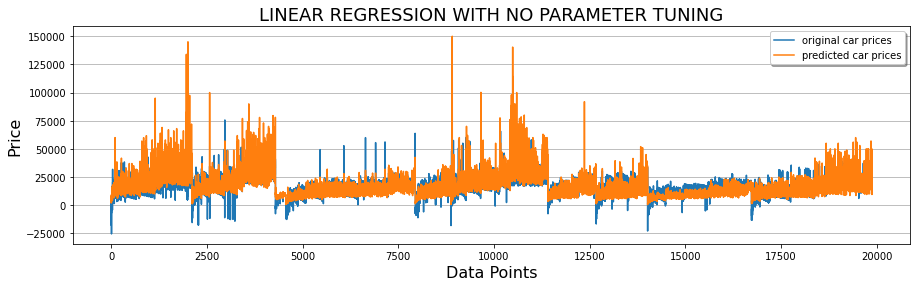

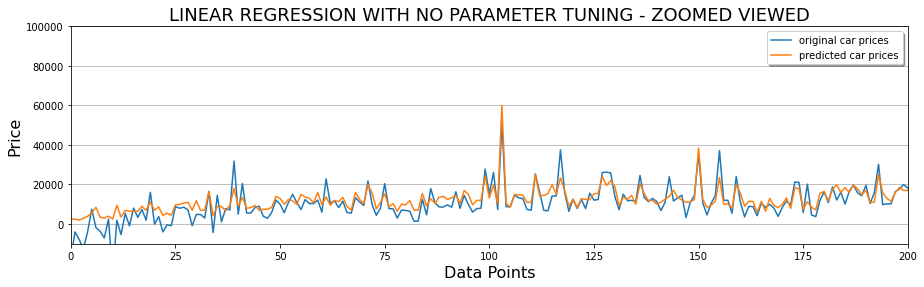

In [0]:
# List of train and test data
data = [train_data, test_data]

# get results of Linear Regression
lr_model, lr_results, lr_rmse, lr_r2, lr_mae = fitModelToCarData(LinearRegression, data, 'lr')

#DELETE FILES
dbutils.fs.rm('dbfs:/models/linear_regression_no_CV/', recurse=True)

# Save the model to file
lr_model.save('dbfs:/models/linear_regression_no_CV/')

title="LINEAR REGRESSION WITH NO PARAMETER TUNING"
plotPrice(lr_results, title = title)
plotPrice(lr_results, 'zoomed', title = title + " - ZOOMED VIEWED")

### GENERALIZED LINEAR REGRESSION

Root Mean Squared Error (RMSE) on test data: 5153.06
Coefficient of Determination (R2) on test data: 73.0%
Mean Absolute Error (MAE) on test data: 3427.84
+-------------------+-----+--------------------+
 prediction|price| scaledFeatures|
+-------------------+-----+--------------------+
-17543.314459542038| 2490|[0.66,0.309595385...|
 -3996.463026363068| 2495|[0.66,0.362227127...|
 -7854.213996731749| 1975|[0.70000000000000...|
-12426.489781457087| 2895|[0.70000000000000...|
-4064.7925164431217| 3888|[0.72,0.247675689...|
+-------------------+-----+--------------------+
only showing top 5 rows

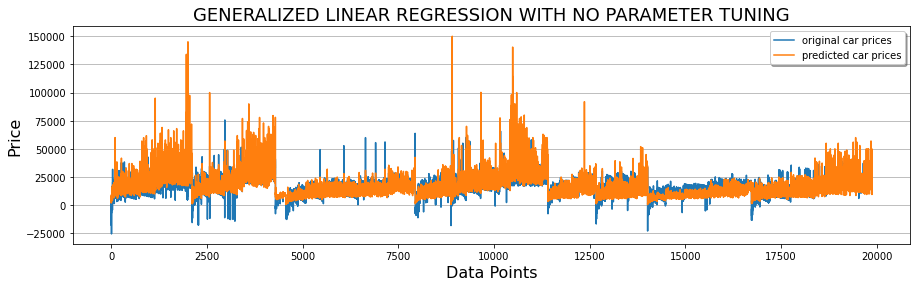

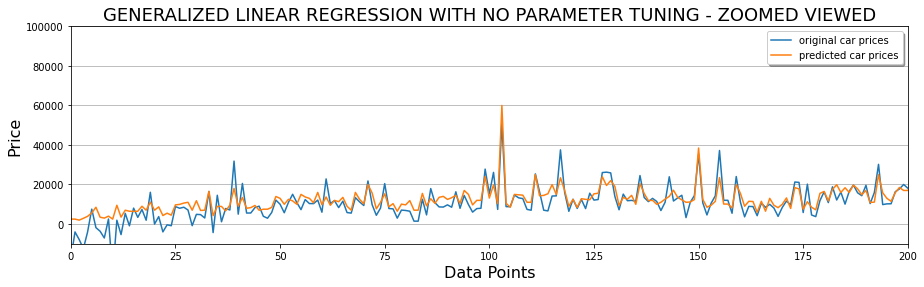

In [0]:
# get results of Linear Regression
glr_model, glr_results, glr_rmse, glr_r2, glr_mae = fitModelToCarData(GeneralizedLinearRegression, data, 'glr')

#DELETE FILES
dbutils.fs.rm('dbfs:/models/generalised_linear_regression_no_CV/', recurse=True)

# Save the model to file
glr_model.save('dbfs:/models/generalised_linear_regression_no_CV/')

title="GENERALIZED LINEAR REGRESSION WITH NO PARAMETER TUNING"
plotPrice(glr_results, title = title)
plotPrice(glr_results, 'zoomed', title = title + " - ZOOMED VIEWED")

### DECISION TREE REGRESSION

Root Mean Squared Error (RMSE) on test data: 4461.77
Coefficient of Determination (R2) on test data: 80.0%
Mean Absolute Error (MAE) on test data: 3040.44
+-----------------+-----+--------------------+
 prediction|price| scaledFeatures|
+-----------------+-----+--------------------+
3828.971655328798| 2490|[0.66,0.309595385...|
13622.15455304929| 2495|[0.66,0.362227127...|
7222.267525035765| 1975|[0.70000000000000...|
3828.971655328798| 2895|[0.70000000000000...|
7222.267525035765| 3888|[0.72,0.247675689...|
+-----------------+-----+--------------------+
only showing top 5 rows

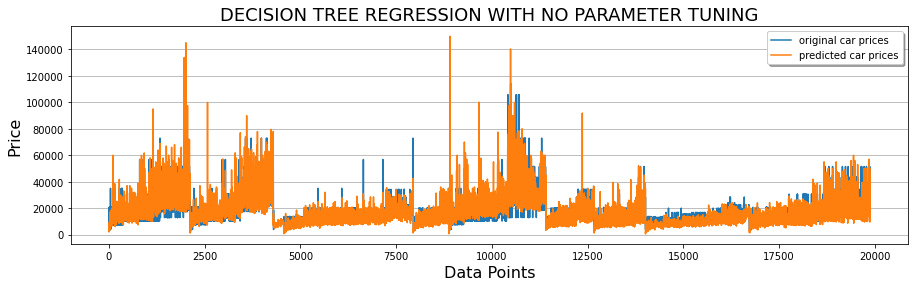

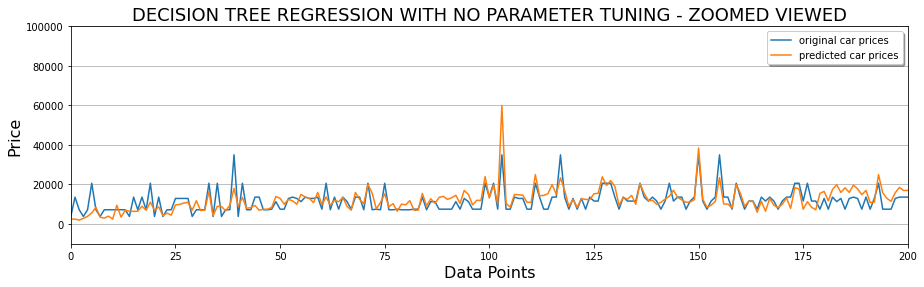

In [0]:
# get results of Decision Tree Regression
dtr_model, dtr_results, dtr_rmse, dtr_r2, dtr_mae = fitModelToCarData(DecisionTreeRegressor, data, 'tree')

#DELETE FILES
dbutils.fs.rm('dbfs:/models/decision_tree_regression_no_CV/', recurse=True)

# Save the model to file
dtr_model.save('dbfs:/models/decision_tree_regression_no_CV/')

title="DECISION TREE REGRESSION WITH NO PARAMETER TUNING"
plotPrice(dtr_results, title = title)
plotPrice(dtr_results, 'zoomed', title = title + " - ZOOMED VIEWED")

### RANDOM FOREST REGRESSION

Root Mean Squared Error (RMSE) on test data: 4238.03
Coefficient of Determination (R2) on test data: 82.0%
Mean Absolute Error (MAE) on test data: 2769.45
+------------------+-----+--------------------+
 prediction|price| scaledFeatures|
+------------------+-----+--------------------+
 7268.303886675012| 2490|[0.66,0.309595385...|
13104.201589890512| 2495|[0.66,0.362227127...|
 7973.448667275227| 1975|[0.70000000000000...|
 5659.588810804491| 2895|[0.70000000000000...|
 7802.963669302897| 3888|[0.72,0.247675689...|
+------------------+-----+--------------------+
only showing top 5 rows

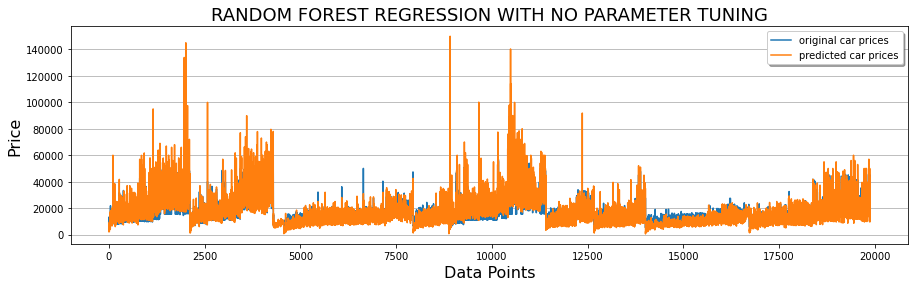

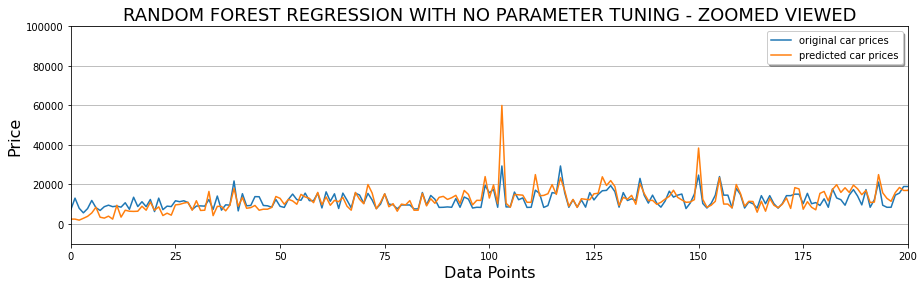

In [0]:
# get results of Random Forest Tree Regression
rf_model, rf_results, rf_rmse, rf_r2, rf_mae = fitModelToCarData(RandomForestRegressor, data, 'tree')

#DELETE FILES
dbutils.fs.rm('dbfs:/models/random_forest_regression_no_CV/', recurse=True)

# Save the model to file
rf_model.save('dbfs:/models/random_forest_regression_no_CV/')

title="RANDOM FOREST REGRESSION WITH NO PARAMETER TUNING"
plotPrice(rf_results, title = title)
plotPrice(rf_results, 'zoomed', title = title + " - ZOOMED VIEWED")

### GRADIENT_BOOSTED TREE REGRESSION

Root Mean Squared Error (RMSE) on test data: 3770.09
Coefficient of Determination (R2) on test data: 85.0%
Mean Absolute Error (MAE) on test data: 2477.56
+-----------------+-----+--------------------+
 prediction|price| scaledFeatures|
+-----------------+-----+--------------------+
3956.559887881626| 2490|[0.66,0.309595385...|
7253.678644110532| 2495|[0.66,0.362227127...|
5262.280057189462| 1975|[0.70000000000000...|
3451.284398806749| 2895|[0.70000000000000...|
5262.280057189462| 3888|[0.72,0.247675689...|
+-----------------+-----+--------------------+
only showing top 5 rows

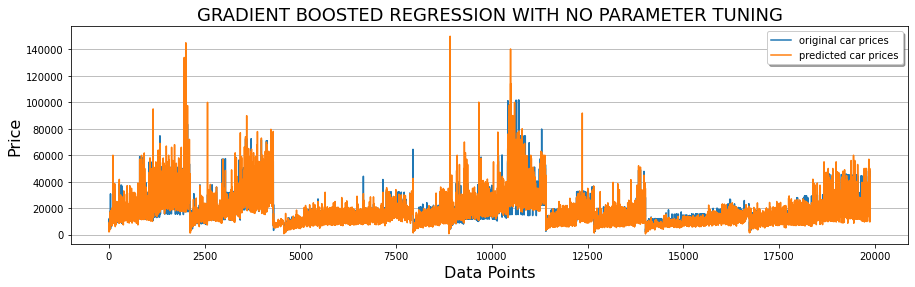

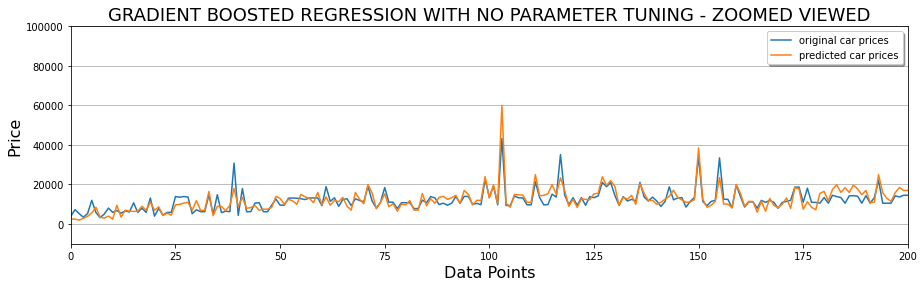

In [0]:
# get results of Random Forest Tree Regression
gbt_model, gbt_results, gbt_rmse, gbt_r2, gbt_mae = fitModelToCarData(GBTRegressor, data)

#DELETE FILES
dbutils.fs.rm('dbfs:/models/gradient_boosted_tree_regression_no_CV/', recurse=True)

# Save the model to file
gbt_model.save('dbfs:/models/gradient_boosted_tree_regression_no_CV/')

title="GRADIENT BOOSTED REGRESSION WITH NO PARAMETER TUNING"
plotPrice(gbt_results, title = title)
plotPrice(gbt_results, 'zoomed', title = title + " - ZOOMED VIEWED")

# Function to perform Cross Validation

In [0]:
def performCrossValidationOnCarData(rg, train_data, test_data, paramGrid):
  
  # evaluate each combination of parameters once  
  crossval = CrossValidator(estimator=rg,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=5) 
  
  
  # To the model to the training data
  rg_model = crossval.fit(train_data)
  
  best_model = rg_model.bestModel

  # Make predictions.
  rg_results = best_model.transform(test_data)
  
  # ================================== COMPUTE RMSE VALUE ==================================#
  evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
  rmse = evaluator.evaluate(rg_results)
  print("Root Mean Squared Error (RMSE) on test data: \t%g" % rmse)

  # ================================== COMPUTE R2 VALUE ==================================#
  evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
  r2 = evaluator.evaluate(rg_results)
  print("Coefficient of Determination (R2) on test data: {}%".format(round(r2*100,0)))

  # ================================== COMPUTE MAE VALUE ==================================#
  evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
  mae = evaluator.evaluate(rg_results)
  print("Mean Absolute Error (MAE) on test data: \t%g" % mae)
  
  # Select example rows to display.
  rg_results = rg_results.withColumnRenamed('label', 'price')
  
  rg_results.select("prediction", "price", "features").show(5)

  return rg_model, rg_results, rmse, r2, mae

### LINEAR REGRESSION

In [0]:
train_data = train_data.withColumnRenamed('scaledFeatures', 'features').withColumnRenamed('price', 'label')
test_data = test_data.withColumnRenamed('scaledFeatures', 'features').withColumnRenamed('price', 'label')

Root Mean Squared Error (RMSE) on test data: 5153.06
Coefficient of Determination (R2) on test data: 73.0%
Mean Absolute Error (MAE) on test data: 3427.85
+-------------------+-----+--------------------+
 prediction|price| features|
+-------------------+-----+--------------------+
-17542.661605596906| 2490|[0.66,0.309595385...|
 -3995.518702638088| 2495|[0.66,0.362227127...|
 -7853.379067568363| 1975|[0.70000000000000...|
-12425.572293523051| 2895|[0.70000000000000...|
 -4063.833467603865| 3888|[0.72,0.247675689...|
+-------------------+-----+--------------------+
only showing top 5 rows

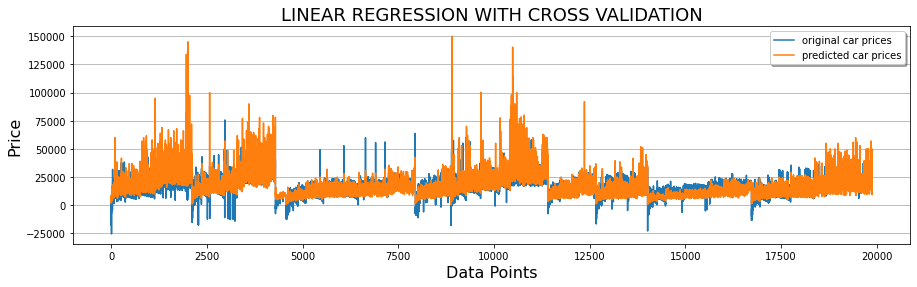

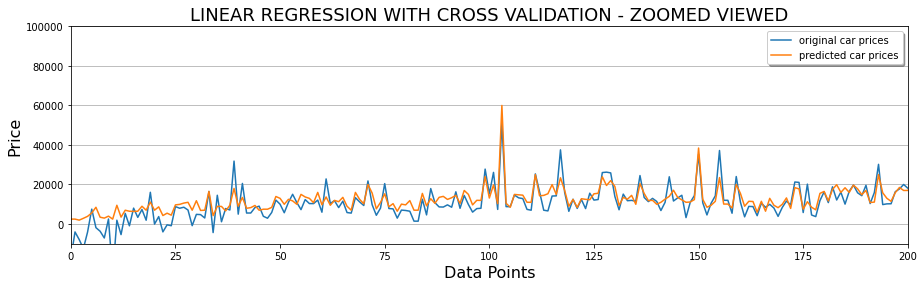

In [0]:
# List of train and test data
data = [train_data, test_data]

lr = LinearRegression()

# creates 12 models from a combination of the parameter grid
lr_paramGrid = ParamGridBuilder()\
      .addGrid(lr.regParam, [0.1, 0.01]) \
      .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
      .build()

# get results of Linear Regression
lr_model_cv, lr_results_cv, lr_rmse_cv, lr_r2_cv, lr_mae_cv = performCrossValidationOnCarData(lr, train_data, test_data, lr_paramGrid)

#DELETE FILES FROM DIRECTORY IF ANY EXISTS
dbutils.fs.rm('dbfs:/models/linear_regression_with_CV/', recurse=True)

# Save the model to file
lr_model_cv.save('dbfs:/models/linear_regression_with_CV/')

title="LINEAR REGRESSION WITH CROSS VALIDATION"
plotPrice(lr_results_cv, title = title)
plotPrice(lr_results_cv, 'zoomed', title = title + " - ZOOMED VIEWED")

### GENERALIZED LINEAR REGRESSION

Root Mean Squared Error (RMSE) on test data: 5153.06
Coefficient of Determination (R2) on test data: 73.0%
Mean Absolute Error (MAE) on test data: 3427.84
+-------------------+-----+--------------------+
 prediction|price| features|
+-------------------+-----+--------------------+
-17543.314459542147| 2490|[0.66,0.309595385...|
 -3996.463026363286| 2495|[0.66,0.362227127...|
-7854.2139967319235| 1975|[0.70000000000000...|
-12426.489781457276| 2895|[0.70000000000000...|
-4064.7925164433254| 3888|[0.72,0.247675689...|
+-------------------+-----+--------------------+
only showing top 5 rows

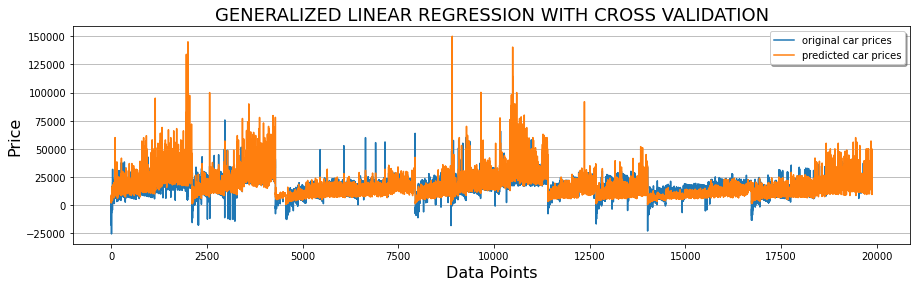

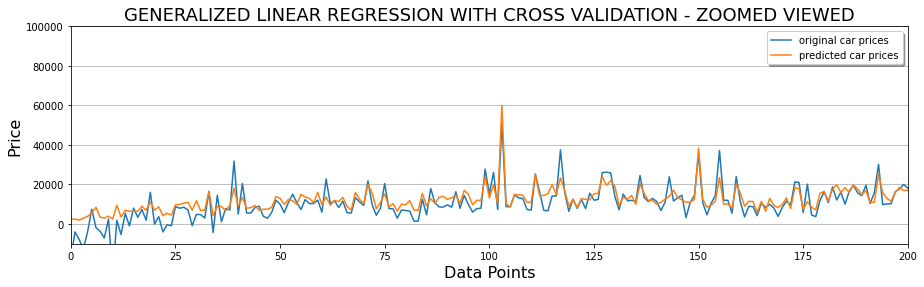

In [0]:
glr = GeneralizedLinearRegression()

# creates 24 models from a combination of the parameter grid
glr_paramGrid = ParamGridBuilder()\
      .addGrid(glr.regParam, [0.1, 0.01]) \
      .addGrid(glr.fitIntercept, [False, True])\
      .build()

    
# get results of Generalized Linear Regression
glr_model_cv, glr_results_cv, glr_rmse_cv, glr_r2_cv, glr_mae_cv = performCrossValidationOnCarData(glr, train_data, test_data, glr_paramGrid)

#DELETE FILES FROM DIRECTORY IF ANY EXISTS
dbutils.fs.rm('dbfs:/models/generalized_linear_regression_with_CV/', recurse=True)

# Save the model to file
glr_model_cv.save('dbfs:/models/generalized_linear_regression_with_CV/')

title="GENERALIZED LINEAR REGRESSION WITH CROSS VALIDATION"
plotPrice(glr_results_cv, title = title)
plotPrice(glr_results_cv, 'zoomed', title = title + " - ZOOMED VIEWED")

### DECISION TREE REGRESSION

Root Mean Squared Error (RMSE) on test data: 4922.15
Coefficient of Determination (R2) on test data: 75.0%
Mean Absolute Error (MAE) on test data: 3359.62
+------------------+-----+--------------------+
 prediction|price| features|
+------------------+-----+--------------------+
6987.0474959612275| 2490|[0.66,0.309595385...|
 18463.66581710674| 2495|[0.66,0.362227127...|
10387.875050060073| 1975|[0.70000000000000...|
6987.0474959612275| 2895|[0.70000000000000...|
10387.875050060073| 3888|[0.72,0.247675689...|
+------------------+-----+--------------------+
only showing top 5 rows

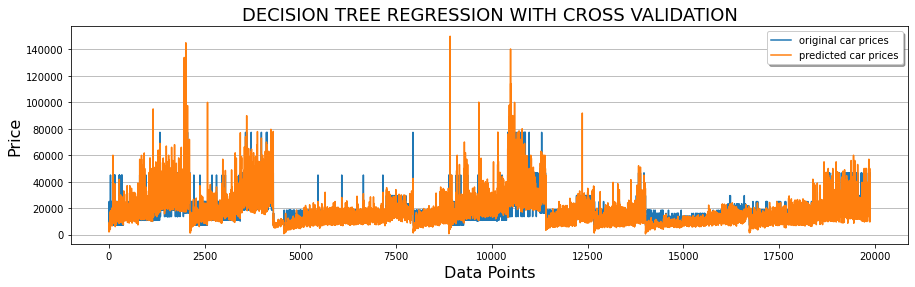

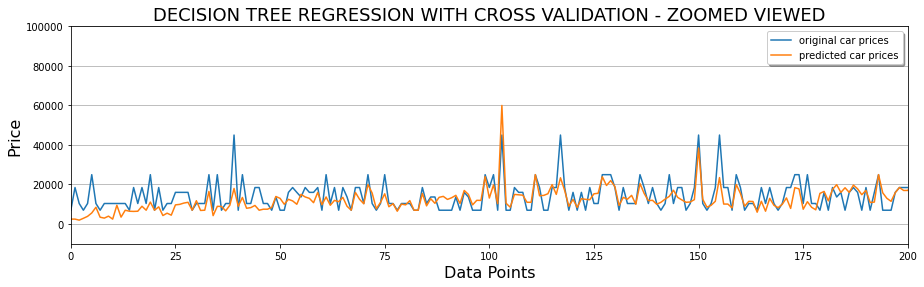

In [0]:
dtr = DecisionTreeRegressor()

# creates 2 models from a combination of the parameter grid
dtr_paramGrid = ParamGridBuilder()\
      .addGrid(dtr.maxDepth, [2, 3, 4]) \
      .build()

# get results of Decision Tree Regression
dtr_model_cv, dtr_results_cv, dtr_rmse_cv, dtr_r2_cv, dtr_mae_cv = performCrossValidationOnCarData(dtr, train_data, test_data, dtr_paramGrid)

#DELETE FILES FROM DIRECTORY IF ANY EXISTS
dbutils.fs.rm('dbfs:/models/decision_tree_regression_with_CV/', recurse=True)

# Save the model to file
dtr_model_cv.save('dbfs:/models/decision_tree_regression_with_CV/')

title="DECISION TREE REGRESSION WITH CROSS VALIDATION"
plotPrice(dtr_results_cv, title = title)
plotPrice(dtr_results_cv, 'zoomed', title = title + " - ZOOMED VIEWED")

### RANDOM FOREST REGRESSION

Root Mean Squared Error (RMSE) on test data: 4671.94
Coefficient of Determination (R2) on test data: 78.0%
Mean Absolute Error (MAE) on test data: 3040.38
+------------------+-----+--------------------+
 prediction|price| features|
+------------------+-----+--------------------+
 8012.136823332947| 2490|[0.66,0.309595385...|
15352.557170275322| 2495|[0.66,0.362227127...|
 10441.41541210939| 1975|[0.70000000000000...|
 6931.292145043473| 2895|[0.70000000000000...|
 10441.41541210939| 3888|[0.72,0.247675689...|
+------------------+-----+--------------------+
only showing top 5 rows

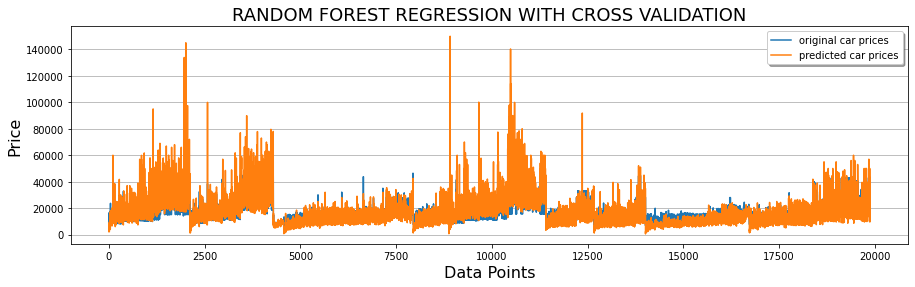

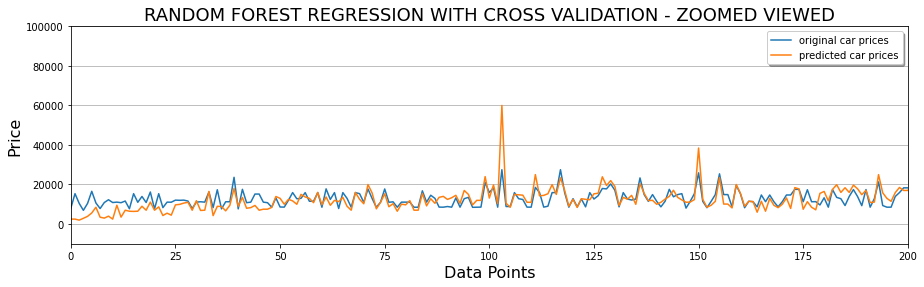

In [0]:
rf = RandomForestRegressor()

# creates x models from a combination of the parameter grid
rf_paramGrid = ParamGridBuilder()\
      .addGrid(rf.maxDepth, [2, 3, 4]) \
      .build()

# get results of Random Forest Regression
rf_model_cv, rf_results_cv, rf_rmse_cv, rf_r2_cv, rf_mae_cv = performCrossValidationOnCarData(rf, train_data, test_data, rf_paramGrid)

#DELETE FILES FROM DIRECTORY IF ANY EXISTS
dbutils.fs.rm('dbfs:/models/random_forest_regression_with_CV/', recurse=True)

# Save the model to file
rf_model_cv.save('dbfs:/models/random_forest_regression_with_CV/')

title="RANDOM FOREST REGRESSION WITH CROSS VALIDATION"
plotPrice(rf_results_cv, title = title)
plotPrice(rf_results_cv, 'zoomed', title = title + " - ZOOMED VIEWED")

### GRADIENT_BOOSTED TREE REGRESSION

Root Mean Squared Error (RMSE) on test data: 2949
Coefficient of Determination (R2) on test data: 91.0%
Mean Absolute Error (MAE) on test data: 1625.22
+------------------+-----+--------------------+
 prediction|price| features|
+------------------+-----+--------------------+
2359.6663692417706| 2490|[0.66,0.309595385...|
 5310.32879543117| 2495|[0.66,0.362227127...|
 2405.291643549152| 1975|[0.70000000000000...|
 3023.311108277936| 2895|[0.70000000000000...|
 4193.589714701149| 3888|[0.72,0.247675689...|
+------------------+-----+--------------------+
only showing top 5 rows

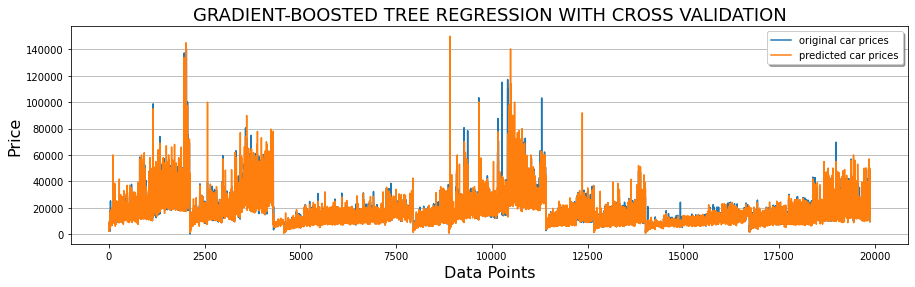

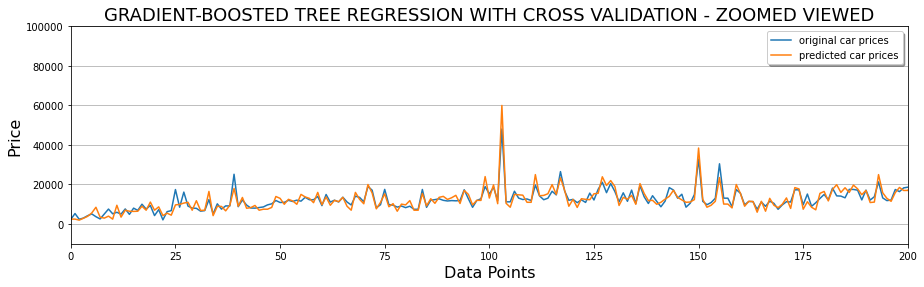

In [0]:
gbt = GBTRegressor()

# creates x models from a combination of the parameter grid
gbt_paramGrid = ParamGridBuilder()\
      .addGrid(gbt.maxDepth, [5, 10]) \
      .addGrid(gbt.maxIter, [5, 10, 15]) \
      .build()

# get results of Decision Tree Regression
gbt_model_cv, gbt_results_cv, gbt_rmse_cv, gbt_r2_cv, gbt_mae_cv = performCrossValidationOnCarData(gbt, train_data, test_data, gbt_paramGrid)


#DELETE FILES FROM DIRECTORY IF ANY EXISTS
dbutils.fs.rm('dbfs:/models/gradient_boosted_tree_regression_with_CV/', recurse=True)

# Save the model to file
gbt_model_cv.save('dbfs:/models/gradient_boosted_tree_regression_with_CV/')

title="GRADIENT-BOOSTED TREE REGRESSION WITH CROSS VALIDATION"
plotPrice(gbt_results_cv, title = title)
plotPrice(gbt_results_cv, 'zoomed', title = title + " - ZOOMED VIEWED")

### EXTREME GRADIENT-BOOST MODEL

We will use Hyperopt, Python library, for serial and parallel optimization over a defined search space, which may include real-valued, discrete, and conditional dimensions.

In [0]:
xgb_car_data = vectorized_car_data.select(['year', 'mileage','tax','mpg','engineSize','transmission_cat','fuelType_cat','make_cat', 'price']).toPandas()

features = xgb_car_data.drop('price', axis=1)
prices = xgb_car_data['price']

print("Shape of features: {}".format(features.shape))
print("Shape of target: {}".format(prices.shape))

Shape of features: (99186, 8)
Shape of target: (99186,)


In [0]:
train_features, test_features, train_prices, test_prices = train_test_split(features, prices, test_size = 0.2, random_state = 0)

print("Size of train dataset: {} rows".format(train_features.shape[0]))
print("Size of test dataset: {} rows".format(test_features.shape[0]))

Size of train dataset: 79348 rows
Size of test dataset: 19838 rows


In [0]:
from sklearn.preprocessing import StandardScaler

# Instantiate the Standardize
scaler = StandardScaler()

# scale the training data
# learn the scaling parameters (mean & variance) of that dataset
train_features_sca = scaler.fit_transform(train_features)

# scale the testing data using the parameters from the training dataset
test_features_sca = scaler.transform(test_features)

In [0]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [0]:
# Regression: 
def hyperparameter_tuning(space):
  model=xgb.XGBRegressor(n_estimators =space['n_estimators'], 
                         max_depth = int(space['max_depth']), 
                         gamma = space['gamma'],
                         reg_alpha = space['reg_alpha'], 
                         reg_lambda = space['reg_lambda'], 
                         colsample_bytree=space['colsample_bytree'],
                         min_child_weight  = space['min_child_weight']
                        )
  
    
  evaluation = [( train_features_sca, train_prices), ( test_features_sca, test_prices)]

  model.fit(train_features_sca, train_prices,
            eval_set = evaluation, 
            eval_metric = "rmse",
            early_stopping_rounds = 10,
            verbose = False)

  predicted_prices = model.predict(test_features_sca)
  mse = mean_squared_error(test_prices, predicted_prices)
  print ("MSE SCORE:", mse)
  
  return {'loss':mse, 'status': STATUS_OK, 'model': model}

In [0]:
trials = Trials()
best_model = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best_model)

MSE SCORE:
5049319.68505377
MSE SCORE:
6519939.067822195
MSE SCORE:
5894354.552416426
MSE SCORE:
5148045.882791853
MSE SCORE:
5074450.177779698
MSE SCORE:
5079427.644608734
MSE SCORE:
5274397.29236049
MSE SCORE:
5153635.928588026
MSE SCORE:
5165254.133050356
MSE SCORE:
5242257.340548337
MSE SCORE:
5140317.5201171115
MSE SCORE:
8182963.121800189
MSE SCORE:
4973024.221023816
MSE SCORE:
5462285.653830392
MSE SCORE:
7844120.109630257
MSE SCORE:
5303305.116199751
MSE SCORE:
5349977.464762053
MSE SCORE:
5343527.6113953665
MSE SCORE:
5131672.817233637
MSE SCORE:
5156176.667763456
MSE SCORE:
5016453.507130256
MSE SCORE:
5109758.403140763
MSE SCORE:
5220009.860704602
MSE SCORE:
5046863.962298754
MSE SCORE:
5253670.266022508
MSE SCORE:
5155399.2397845285
MSE SCORE:
5202436.803815564
MSE SCORE:
5129844.147740547
MSE SCORE:
5040909.299566981
MSE SCORE:
5262693.0990583645
MSE SCORE:
5057055.431522036
MSE SCORE:
4987670.85957812
MSE SCORE:
4810785.704819984
MSE SCORE:
5100511.999949611
MSE SCORE:
51

In [0]:
best_model

Out[34]: {'colsample_bytree': 0.7191781540935325,
 'gamma': 5.846925061674012,
 'max_depth': 13.0,
 'min_child_weight': 7.0,
 'reg_alpha': 129.0,
 'reg_lambda': 0.6205088978364781}

In [0]:
data = [train_features_sca, train_prices, test_features_sca, test_prices]

def fitBestXGBModel(data, best_model):
  
  model = xgb.XGBRegressor(n_estimators = 100, 
                          max_depth = int(best_model['max_depth']), 
                          gamma = best_model['gamma'],
                          reg_alpha = best_model['reg_alpha'], 
                          colsample_bytree = best_model['colsample_bytree'],
                          min_child_weight  = best_model['min_child_weight'],
                          reg_lambda = best_model['reg_lambda'],
                          eta = 0.35 #best_model['eta']
                        )
  
  xgb_model = model.fit(data[0], data[1])
  
  predicted_prices = xgb_model.predict(data[2])

  # ================================== COMPUTE RMSE VALUE ==================================#
  rmse = math.sqrt(mean_squared_error(data[3], predicted_prices))
  print("Root Mean Squared Error (RMSE) on test data: \t%g" % rmse)

  # ================================== COMPUTE R2 VALUE ==================================#
  r2 = r2_score(data[3], predicted_prices)
  print("Coefficient of Determination (R2) on test data: {}%".format(round(r2*100,0)))

  # ================================== COMPUTE MAE VALUE ==================================#
  mae = mean_absolute_error(data[3], predicted_prices)
  print("Mean Absolute Error (MAE) on test data: \t%g" % mae)
  
  return xgb_model, predicted_prices, rmse, mae, r2

In [0]:
def plotXGBPrice(orig_prices, pred_prices, view=None, title=None):
  
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (15,10)
    plt.subplots_adjust(hspace = .5)

    x_ax = range(0, len(orig_prices))

    if view != 'zoomed':
        plt.subplot(2, 1, 1)
        plt.plot(x_ax, orig_prices, label="original car prices")
        plt.plot(x_ax, pred_prices, label="predicted car prices")
        plt.ylabel('Price', fontsize=16)
        plt.xlabel('Data Points', fontsize=16)
        plt.title(title, fontsize=18)
        plt.legend(loc='best',fancybox=True, shadow=True)
    else:
        plt.subplot(2, 1, 2)
        plt.plot(x_ax, orig_prices, label="original car prices")
        plt.plot(x_ax, pred_prices, label="predicted car prices")
        plt.ylabel('Price', fontsize=16)
        plt.xlabel('Data Points', fontsize=16)
        plt.title(title, fontsize=18)
        plt.xlim(0,200)
        plt.ylim(-10000,100000)

    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True, axis='y')
    plt.show() 

In [0]:
# Create directory for saving and loading trained model
model_dir = os.path.join(os.getcwd(), "trained_models/xgb_regression_with_hyperparameter_tuning")

# ensure cache directory exists
os.makedirs(model_dir, exist_ok=True)  


def save_model(model, model_file, model_dir = model_dir):
    """
        Saves the model into the model directory.
        
        args:
            model - the trained model
            model_file - the name of the model saved as a pickle file
            model_dir - the directory to save the model into      
    """
    with open(os.path.join(model_dir, model_file), 'wb') as f:
            joblib.dump(model, f)

Root Mean Squared Error (RMSE) on test data: 	2247.12
Coefficient of Determination (R2) on test data: 95.0%
Mean Absolute Error (MAE) on test data: 	1355.18


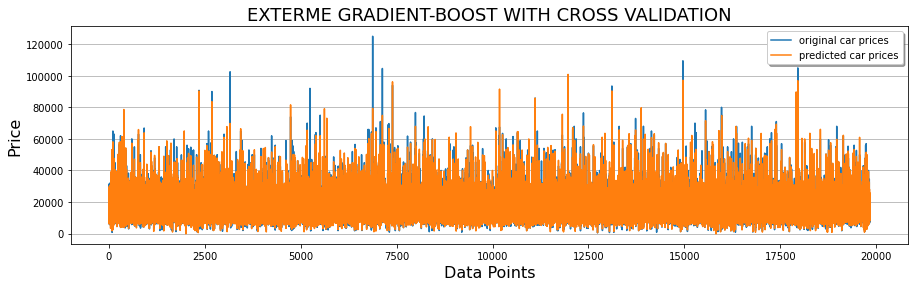

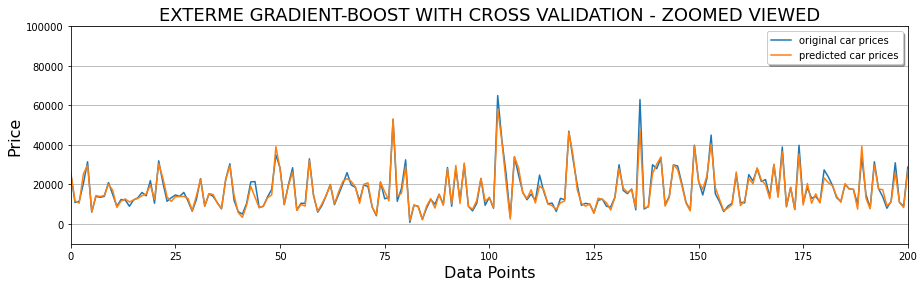

In [0]:
xgb_model, predicted_prices, xgb_rmse, xgb_mae, xgb_r2 = fitBestXGBModel(data, best_model)

# Save the Model
#save_model(xgb_model, 'xgb_model.pkl')

title="EXTERME GRADIENT-BOOST WITH CROSS VALIDATION"
plotXGBPrice(test_prices, predicted_prices, title = title)
plotXGBPrice(test_prices, predicted_prices, 'zoomed', title = title + " - ZOOMED VIEWED")

Overall, XGBoost model produced the best result in terms of performance metrics, however during web deployment, the model was unable to process the categorical input data. This was due to the string indexing performed on the training and test data to convert categorical data to numerical data, and also the data structure with which the model the XGB model was trained.

Research showed that XGB models deals with categorical data better if the data is transformed into a specific format known as **DMatrix**,  which is an internal data structure used by XGBoost and  optimized for both memory efficiency and training speed.

The following shows how this transformation is performed.

- we start with the `new_car_data` from above, which includes the new categorical columns converted to string index
- select the appropriate columns
- select the features and target (prices)
- split to training and testing datasets
- normalize the data by applying StandardScalar()
- convert to DMatrix

In [0]:
new_car_data = vectorized_car_data.toPandas()[['year', 'mileage','tax','mpg','engineSize','transmission_cat','fuelType_cat','make_cat', 'price']]
new_car_data.head()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


year 
 mileage 
 tax 
 mpg 
 engineSize 
 transmission_cat 
 fuelType_cat 
 make_cat 
 price 
 
 
 
 
 0 
 2017 
 15735 
 150 
 55.4 
 1.4 
 0.0 
 0.0 
 5.0 
 12500 
 
 
 1 
 2016 
 36203 
 20 
 64.2 
 2.0 
 2.0 
 1.0 
 5.0 
 16500 
 
 
 2 
 2016 
 29946 
 30 
 55.4 
 1.4 
 0.0 
 0.0 
 5.0 
 11000 
 
 
 3 
 2017 
 25952 
 145 
 67.3 
 2.0 
 2.0 
 1.0 
 5.0 
 16800 
 
 
 4 
 2019 
 1998 
 145 
 49.6 
 1.0 
 0.0 
 0.0 
 5.0 
 17300

In [0]:
features = new_car_data.drop('price', axis=1)
prices = new_car_data['price']

print("Shape of features: {}".format(features.shape))
print("Shape of target: {}".format(prices.shape))

Shape of features: (99186, 8)
Shape of target: (99186,)


In [0]:
train_features, test_features, train_prices, test_prices = train_test_split(features, prices, test_size = 0.1, random_state = 0)

print("Size of train dataset: {} rows".format(train_features.shape[0]))
print("Size of test dataset: {} rows".format(test_features.shape[0]))

Size of train dataset: 89267 rows
Size of test dataset: 9919 rows


In [0]:
def scaleData(train_features, test_features):
  # Instantiate the Standardize
  scaler = StandardScaler()

  # scale the training data
  # learn the scaling parameters (mean & variance) of that dataset
  train_features_sca = scaler.fit_transform(train_features)

  # scale the testing data using the parameters from the training dataset
  test_features_sca = scaler.transform(test_features)
  
  return train_features_sca, test_features_sca

In [0]:
train_features_sca, test_features_sca = scaleData(train_features, test_features)

print("Size of train dataset: {} rows".format(train_features_sca.shape[0]))
print("Size of test dataset: {} rows".format(test_features_sca.shape[0]))

Size of train dataset: 89267 rows
Size of test dataset: 9919 rows


In [0]:
data = [train_features_sca, train_prices, test_features_sca, test_prices]

def fitBestXGBModel(data):
    
    # convert to DMatrix
    dtrain = xgb.DMatrix(data[0], label=data[1])
    dtest = xgb.DMatrix(data[2], label=data[3])
    
    param = {
        'colsample_bytree': 0.8147816519950666,
        'gamma': 4.418467454069788,
        'max_depth': 14,
        'min_child_weight': 7.0,
        'reg_alpha': 142.0,
        'reg_lambda': 0.6756818735043552,
        'eta': 0.35
        }

    xgb_model = xgb.train(param, dtrain)

    predicted_prices = xgb_model.predict(dtest)

    # ================================== COMPUTE RMSE VALUE ==================================#
    rmse = math.sqrt(mean_squared_error(data[3], predicted_prices))
    print("Root Mean Squared Error (RMSE) on test data: \t%g" % rmse)

    # ================================== COMPUTE R2 VALUE ==================================#
    r2 = r2_score(data[3], predicted_prices)
    print("Coefficient of Determination (R2) on test data: {}%".format(round(r2*100,0)))

    # ================================== COMPUTE MAE VALUE ==================================#
    mae = mean_absolute_error(data[3], predicted_prices)
    print("Mean Absolute Error (MAE) on test data: \t%g" % mae)

    return xgb_model, predicted_prices, rmse, mae, r2

In [0]:
def plotXGBPrice(orig_prices, pred_prices, view=None, title=None):
  
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (15,10)
    plt.subplots_adjust(hspace = .5)

    x_ax = range(0, len(orig_prices))

    if view != 'zoomed':
        plt.subplot(2, 1, 1)
        plt.plot(x_ax, orig_prices, label="original car prices")
        plt.plot(x_ax, pred_prices, label="predicted car prices")
        plt.ylabel('Price', fontsize=16)
        plt.xlabel('Data Points', fontsize=16)
        plt.title(title, fontsize=18)
        plt.legend(loc='best',fancybox=True, shadow=True)
    else:
        plt.subplot(2, 1, 2)
        plt.plot(x_ax, orig_prices, label="original car prices")
        plt.plot(x_ax, pred_prices, label="predicted car prices")
        plt.ylabel('Price', fontsize=16)
        plt.xlabel('Data Points', fontsize=16)
        plt.title(title, fontsize=18)
        plt.xlim(0,200)
        plt.ylim(-10000,100000)

    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True, axis='y')
    plt.show() 

Root Mean Squared Error (RMSE) on test data: 	2345.45
Coefficient of Determination (R2) on test data: 94.0%
Mean Absolute Error (MAE) on test data: 	1381.15


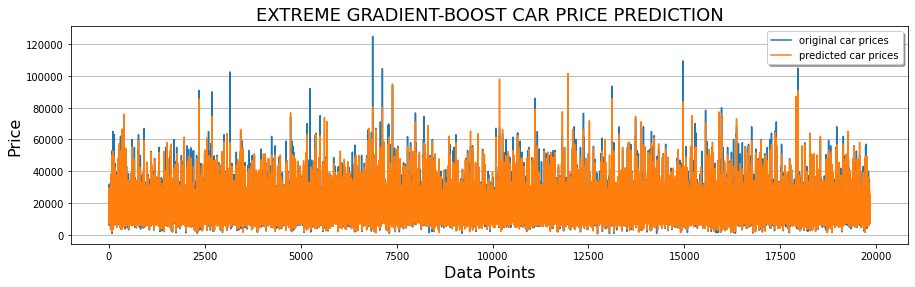

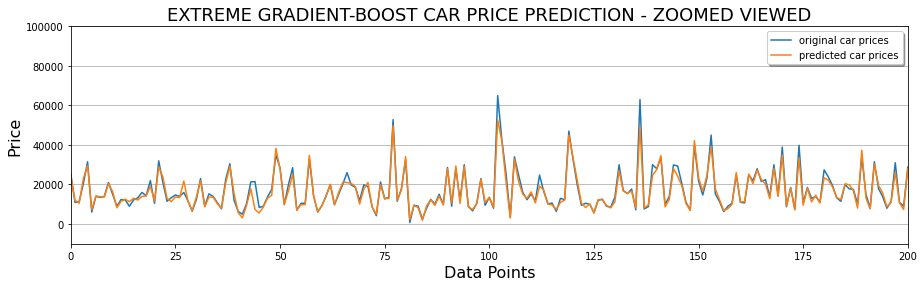

In [0]:
xgb_model, predicted_prices, xgb_rmse, xgb_mae, xgb_r2 = fitBestXGBModel(data)
xgb_model.save_model("xgb_dmatrix.model")

plotXGBPrice(test_prices, predicted_prices, title = "EXTREME GRADIENT-BOOST CAR PRICE PREDICTION")
plotXGBPrice(test_prices, predicted_prices, 'zoomed', title = "EXTREME GRADIENT-BOOST CAR PRICE PREDICTION - ZOOMED VIEWED")

### Predicting the error to assess the model's ability to predict the prediction errors

In [0]:
prediction_error = test_prices - predicted_prices

Out[129]: <matplotlib.legend.Legend at 0x7f9686a42880>

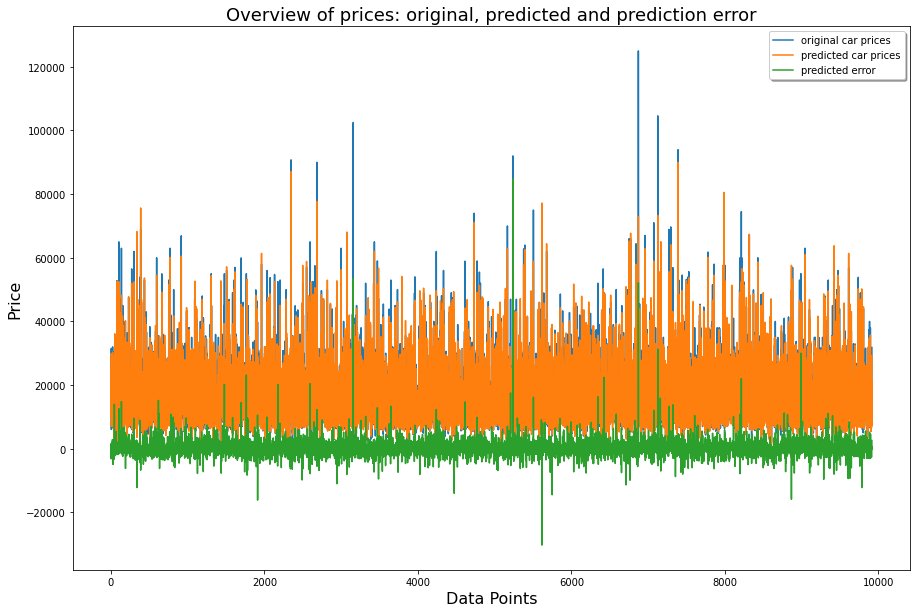

In [0]:
plt.rcParams["figure.figsize"] = (15,10)
x_ax = range(0, len(prediction_error))

title = 'Overview of prices: original, predicted and prediction error'
plt.plot(x_ax, test_prices, label="original car prices")
plt.plot(x_ax, predicted_prices, label="predicted car prices")
plt.plot(x_ax, prediction_error, label="predicted error")
plt.ylabel('Price', fontsize=16)
plt.xlabel('Data Points', fontsize=16)
plt.title(title, fontsize=18)
plt.legend(loc='best',fancybox=True, shadow=True)

In [0]:
prediction_error.describe()

Out[130]: count     9919.000000
mean       269.538573
std       2428.018500
min     -30296.937500
25%       -654.763672
50%        166.143555
75%       1023.785645
max      84785.209473
Name: price, dtype: float64

In [0]:
features_err = test_features_sca # the new X: the prediction errors were generated from the test features
error_prices = prediction_error  # the new y

train_features_err, test_features_err, train_prices_err, test_prices_err = train_test_split(features_err, error_prices, test_size = 0.1, random_state = 0) # 90% trainn, 10^% test

train_features_sca_err, test_features_sca_err = scaleData(train_features_err, test_features_err)

print("Size of train error dataset: {} rows".format(train_prices_err.shape[0]))
print("Size of test error dataset: {} rows".format(test_prices_err.shape[0]))

Size of train error dataset: 8927 rows
Size of test error dataset: 992 rows


In [0]:
def plotXGBErrorPrice(orig_error_prices, pred_error_prices, view=None, title=None):
  
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (15,10)
    plt.subplots_adjust(hspace = .5)

    x_ax = range(0, len(orig_error_prices))

    if view != 'zoomed':
        plt.subplot(2, 1, 1)
        plt.plot(x_ax, orig_error_prices, label="original error")
        plt.plot(x_ax, pred_error_prices, label="predicted error")
        plt.ylabel('Price', fontsize=16)
        plt.xlabel('Data Points', fontsize=16)
        plt.title(title, fontsize=18)
        plt.legend(loc='best',fancybox=True, shadow=True)
    else:
        plt.subplot(2, 1, 2)
        plt.plot(x_ax, orig_error_prices, label="original error")
        plt.plot(x_ax, pred_error_prices, label="predicted error")
        plt.ylabel('Price', fontsize=16)
        plt.xlabel('Data Points', fontsize=16)
        plt.title(title, fontsize=18)
        plt.xlim(0,300)
        plt.ylim(-15000,15000)

    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True, axis='y')
    plt.show() 

Root Mean Squared Error (RMSE) on test data: 	2466.99
Coefficient of Determination (R2) on test data: -16.0%
Mean Absolute Error (MAE) on test data: 	1466.05


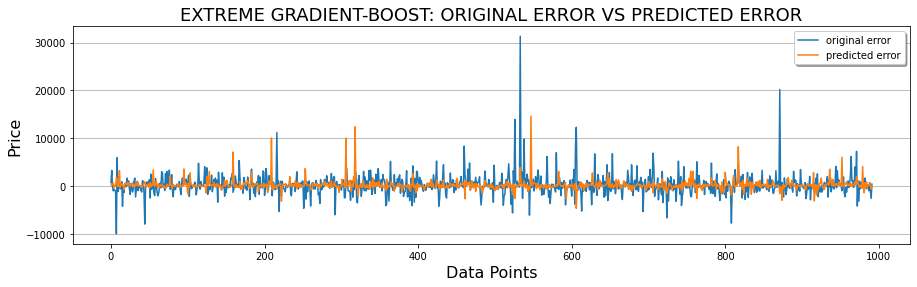

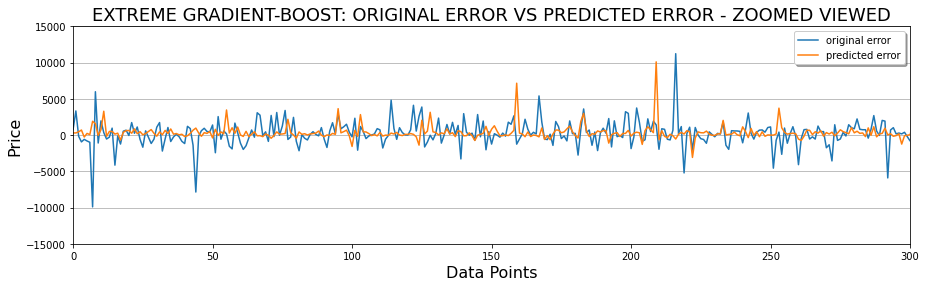

In [0]:
data = [train_features_sca_err, train_prices_err, test_features_sca_err, test_prices_err]

xgb_model_err, predicted_prices_err, xgb_rmse_err, xgb_mae_err, xgb_r2_err = fitBestXGBModel(data)
xgb_model.save_model("xgb_dmatrix.model")

plotXGBErrorPrice(test_prices_err, predicted_prices_err, title = "EXTREME GRADIENT-BOOST: ORIGINAL ERROR VS PREDICTED ERROR")
plotXGBErrorPrice(test_prices_err, predicted_prices_err, 'zoomed', title = "EXTREME GRADIENT-BOOST: ORIGINAL ERROR VS PREDICTED ERROR - ZOOMED VIEWED")